In [1]:
!pip install event2vector opentsne

In [2]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import cosine_similarity
from event2vector import Event2Vec

nltk.download('udhr')
from nltk.corpus import udhr

# 1. Select a diverse subset of Latin-script languages
lang_ids = [
    # Germanic
    'English-Latin1', 'German_Deutsch-Latin1',
    'Dutch_Nederlands-Latin1', 'Swedish_Svenska-Latin1',
    # Romance
    'Spanish_Espanol-Latin1', 'French_Francais-Latin1',
    'Italian_Italiano-Latin1', 'Portuguese_Portugues-Latin1',
    # Slavic
    'Polish_Polski-Latin2', 'Czech-Latin2',
    # Uralic (Control group - different grammar/roots)
    'Finnish_Suomi-Latin1', 'Hungarian_Magyar-Latin1'
]

# Map nice names for the plot
lang_names = {
    'English-Latin1': 'English', 'German_Deutsch-Latin1': 'German',
    'Dutch_Nederlands-Latin1': 'Dutch', 'Swedish_Svenska-Latin1': 'Swedish',
    'Spanish_Espanol-Latin1': 'Spanish', 'French_Francais-Latin1': 'French',
    'Italian_Italiano-Latin1': 'Italian', 'Portuguese_Portugues-Latin1': 'Portuguese',
    'Polish_Polski-Latin2': 'Polish', 'Czech-Latin2': 'Czech',
    'Finnish_Suomi-Latin1': 'Finnish', 'Hungarian_Magyar-Latin1': 'Hungarian'
}

def load_polyglot_data(lang_ids, seq_length=30):
    all_sequences = []
    lang_labels = [] # To track which language a sequence belongs to

    # 1. Build Global Vocabulary first
    global_text = ""
    for lid in lang_ids:
        # Latin1 handles most, ignoring errors helps clean dirty bytes
        raw = udhr.raw(lid).encode('latin-1', 'ignore').decode('latin-1')
        clean = [c.lower() for c in raw if c.isalnum() or c in " "]
        global_text += "".join(clean)

    vocab = sorted(list(set(global_text)))
    char2idx = {c: i for i, c in enumerate(vocab)}

    # 2. Process sequences
    for lid in lang_ids:
        raw = udhr.raw(lid).encode('latin-1', 'ignore').decode('latin-1')
        clean_text = [c.lower() for c in raw if c.isalnum() or c in " "]

        # Create sequences
        for i in range(0, len(clean_text) - seq_length, 10): # Stride 10
            seq = [char2idx[c] for c in clean_text[i:i+seq_length] if c in char2idx]
            if len(seq) == seq_length:
                all_sequences.append(seq)
                lang_labels.append(lang_names[lid])

    return all_sequences, lang_labels, char2idx

sequences, labels, char2idx = load_polyglot_data(lang_ids)
print(f"Total Polyglot Sequences: {len(sequences)}")
print(f"Global Vocabulary Size: {len(char2idx)} characters")

Total Polyglot Sequences: 11517
Global Vocabulary Size: 60 characters


[nltk_data] Downloading package udhr to /root/nltk_data...
[nltk_data]   Package udhr is already up-to-date!


In [3]:
# Train the Polyglot Model
model_poly = Event2Vec(
    num_event_types=len(char2idx),
    embedding_dim=48, # Slightly larger dim to accommodate multiple languages
    geometry="euclidean",
    pad_sequences=True,
    batch_size=1024,
    num_epochs=40,
    learning_rate=0.003
)

print("Training Polyglot Event2Vec (this may take a minute)...")
model_poly.fit(sequences, verbose=True)

Training Polyglot Event2Vec (this may take a minute)...
Epoch 1/40 - loss: 3.9750
Epoch 2/40 - loss: 3.6249
Epoch 3/40 - loss: 3.4700
Epoch 4/40 - loss: 3.3783
Epoch 5/40 - loss: 3.3248
Epoch 6/40 - loss: 3.2893
Epoch 7/40 - loss: 3.2687
Epoch 8/40 - loss: 3.2575
Epoch 9/40 - loss: 3.2496
Epoch 10/40 - loss: 3.2419
Epoch 11/40 - loss: 3.2380
Epoch 12/40 - loss: 3.2342
Epoch 13/40 - loss: 3.2296
Epoch 14/40 - loss: 3.2256
Epoch 15/40 - loss: 3.2245
Epoch 16/40 - loss: 3.2181
Epoch 17/40 - loss: 3.2179
Epoch 18/40 - loss: 3.2095
Epoch 19/40 - loss: 3.2090
Epoch 20/40 - loss: 3.2057
Epoch 21/40 - loss: 3.2028
Epoch 22/40 - loss: 3.1991
Epoch 23/40 - loss: 3.1959
Epoch 24/40 - loss: 3.1945
Epoch 25/40 - loss: 3.1900
Epoch 26/40 - loss: 3.1865
Epoch 27/40 - loss: 3.1821
Epoch 28/40 - loss: 3.1808
Epoch 29/40 - loss: 3.1779
Epoch 30/40 - loss: 3.1770
Epoch 31/40 - loss: 3.1728
Epoch 32/40 - loss: 3.1707
Epoch 33/40 - loss: 3.1669
Epoch 34/40 - loss: 3.1634
Epoch 35/40 - loss: 3.1615
Epoch 36

Encoding sequences...


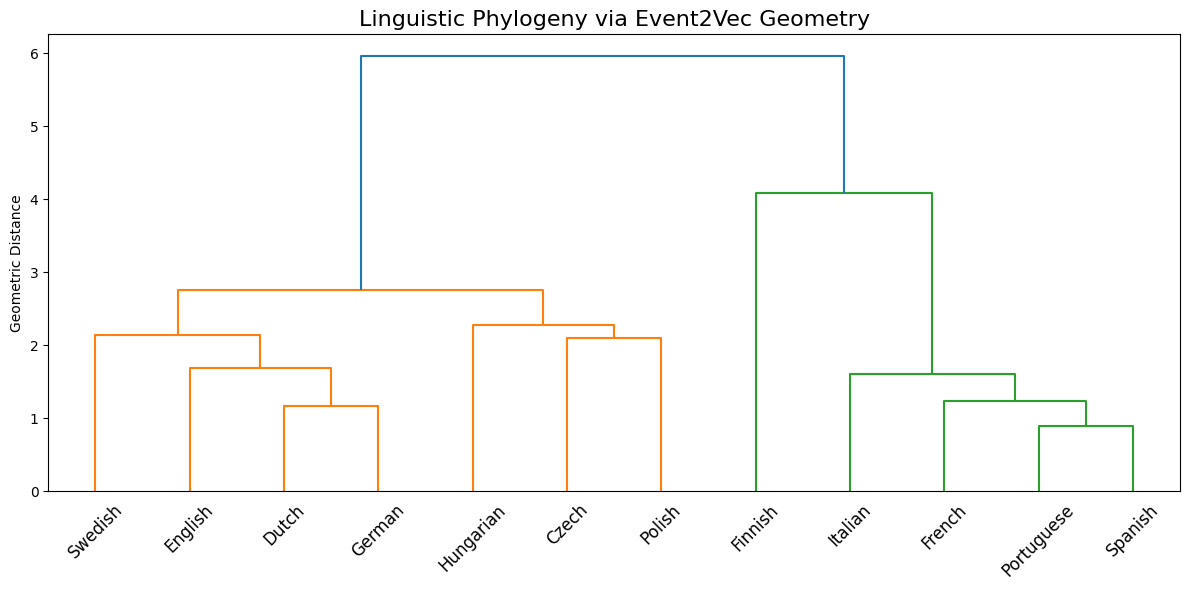

In [4]:
def plot_language_dendrogram(model, sequences, labels):
    # 1. Get embeddings for all sequences
    # Transform returns a numpy array of shape (N, embedding_dim)
    print("Encoding sequences...")
    seq_vectors = model.transform(sequences)

    # 2. Compute Centroids
    unique_langs = sorted(list(set(labels)))
    lang_centroids = []

    for lang in unique_langs:
        # Find indices belonging to this language
        indices = [i for i, x in enumerate(labels) if x == lang]
        # Get vectors
        vecs = seq_vectors[indices]
        # Average them to get the "Language Vector"
        centroid = np.mean(vecs, axis=0)
        lang_centroids.append(centroid)

    lang_centroids = np.array(lang_centroids)

    # 3. Hierarchical Clustering
    # We use 'cosine' distance because direction matters more than magnitude in embeddings
    Z = linkage(lang_centroids, method='ward') # Ward's method usually gives clean clusters

    # 4. Plot
    plt.figure(figsize=(12, 6))
    dendrogram(
        Z,
        labels=unique_langs,
        leaf_rotation=45,
        leaf_font_size=12,
        orientation='top'
    )
    plt.title("Linguistic Phylogeny via Event2Vec Geometry", fontsize=16)
    plt.ylabel("Geometric Distance")
    plt.tight_layout()
    plt.show()

plot_language_dendrogram(model_poly, sequences, labels)

Computing language centroids using PCA...


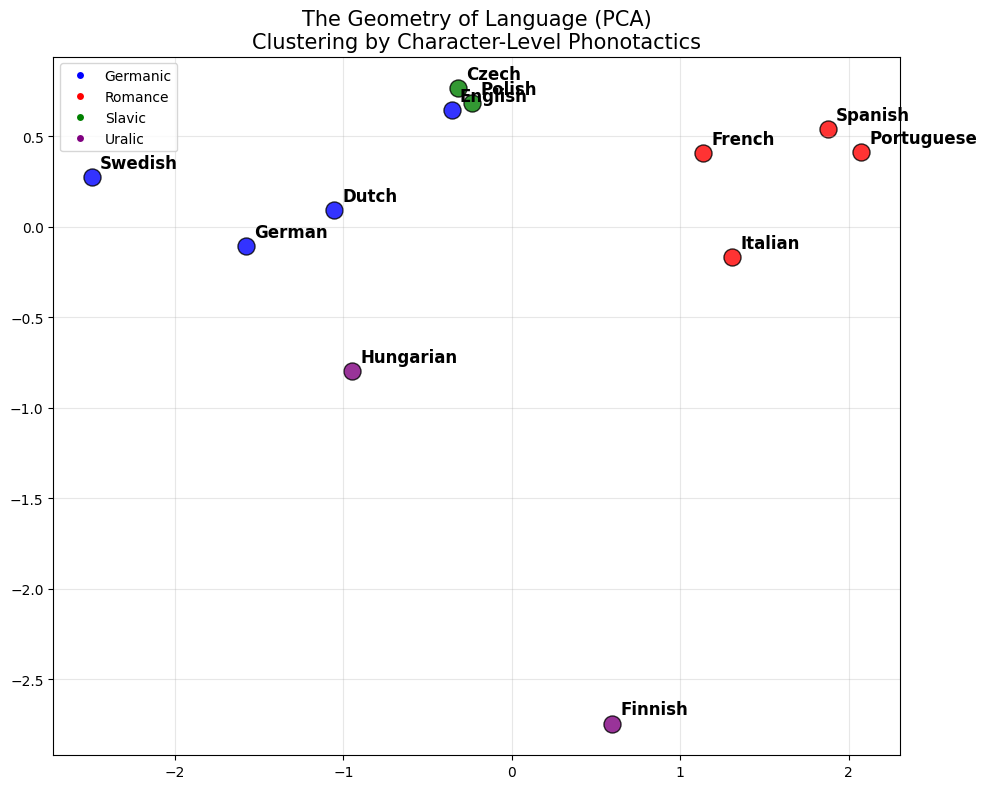

In [6]:
from sklearn.decomposition import PCA

def visualize_language_map(model, sequences, labels, method='pca'):
    """
    Visualizes the geometric relationship between languages.
    Each point is the 'Centroid' of a language (average of its sequence vectors).
    """
    print(f"Computing language centroids using {method.upper()}...")

    # 1. Transform all sequences to vectors
    # This might take a moment for the full dataset
    vecs = model.transform(sequences)

    # 2. Compute the "Average Vector" for each language
    unique_langs = sorted(list(set(labels)))
    centroids = []

    for lang in unique_langs:
        # Get all vectors belonging to this language
        lang_indices = [i for i, x in enumerate(labels) if x == lang]
        lang_vecs = vecs[lang_indices]

        # The centroid represents the "Average Spelling" of that language
        mean_vec = np.mean(lang_vecs, axis=0)
        centroids.append(mean_vec)

    centroids = np.array(centroids)

    # 3. Reduce Dimensions
    if method == 'tsne':
        # Perplexity must be < n_samples
        reducer = TSNE(n_components=2, perplexity=min(5, len(unique_langs)-1), random_state=42)
    else:
        reducer = PCA(n_components=2)

    coords = reducer.fit_transform(centroids)

    # 4. Plot
    plt.figure(figsize=(10, 8))

    # Define color families for the plot
    families = {
        'Germanic': ['English', 'German', 'Dutch', 'Swedish'],
        'Romance': ['Spanish', 'French', 'Italian', 'Portuguese'],
        'Slavic': ['Polish', 'Czech'],
        'Uralic': ['Finnish', 'Hungarian']
    }

    for i, lang in enumerate(unique_langs):
        x, y = coords[i]

        # Determine color by family
        color = 'gray'
        for fam, members in families.items():
            if any(m in lang for m in members): # Simple substring match
                if fam == 'Germanic': color = 'blue'
                elif fam == 'Romance': color = 'red'
                elif fam == 'Slavic': color = 'green'
                elif fam == 'Uralic': color = 'purple'

        plt.scatter(x, y, color=color, s=150, alpha=0.8, edgecolors='k')
        plt.text(x + 0.05, y + 0.05, lang, fontsize=12, weight='bold')

    # Add a custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', label='Germanic'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Romance'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='Slavic'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', label='Uralic')
    ]
    plt.legend(handles=legend_elements, loc='best')

    plt.title(f"The Geometry of Language ({method.upper()})\nClustering by Character-Level Phonotactics", fontsize=15)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_language_map(model_poly, sequences, labels, method='pca')

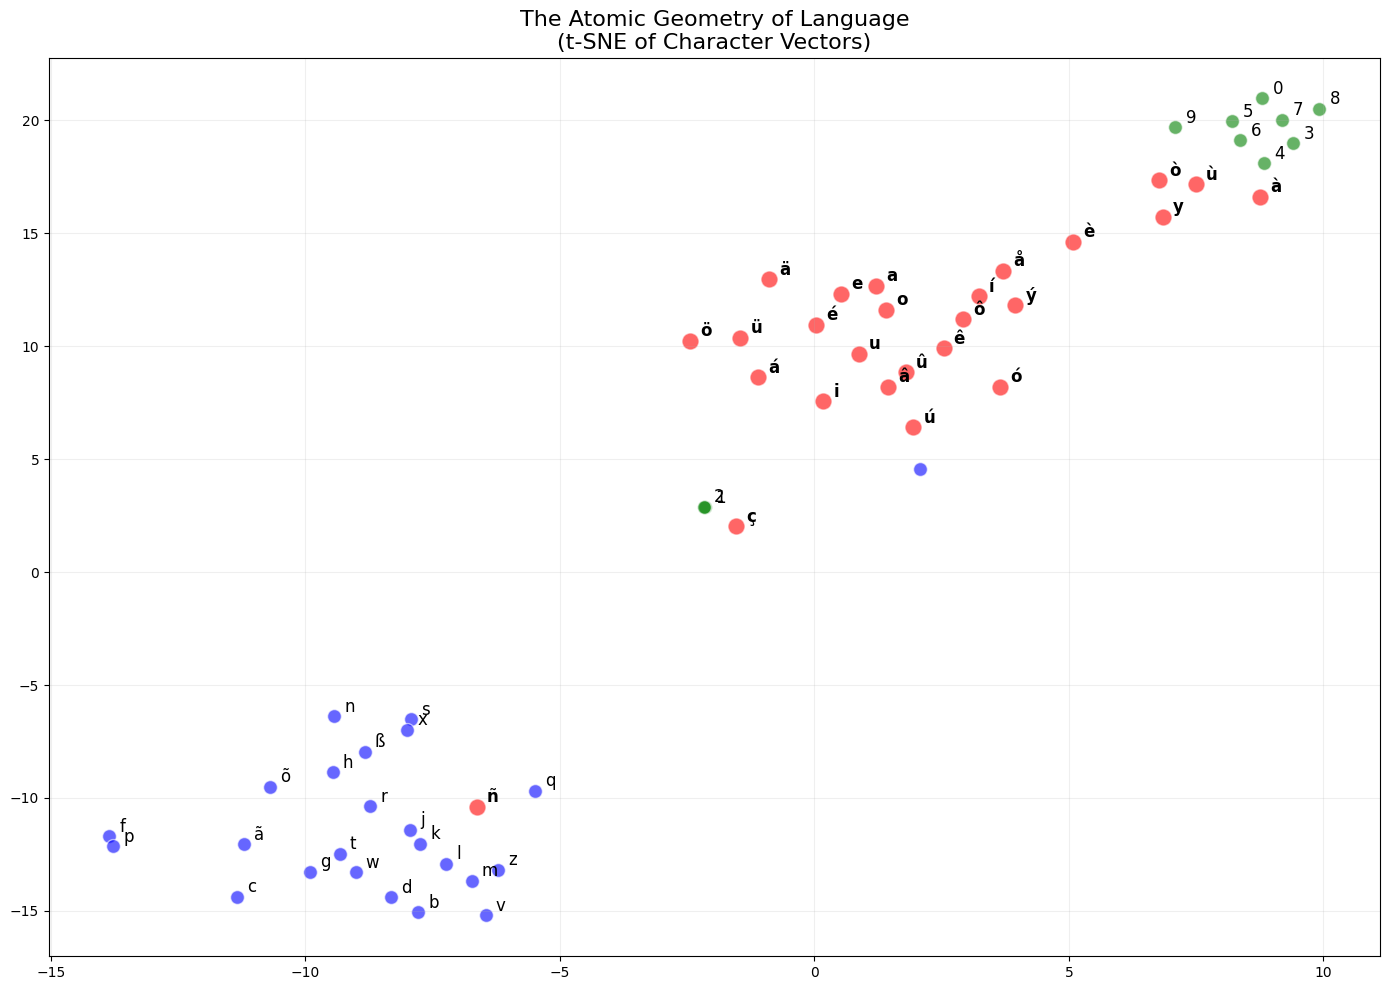

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def visualize_alphabet_map(model, char2idx, perplexity=15):
    """
    Extracts individual character embeddings and visualizes them using t-SNE.
    """
    # 1. Extract Weights
    # The embedding layer contains the raw 'event vectors'
    # Shape: (Vocab_Size, Embedding_Dim)
    weights = model.model.embedding.weight.detach().cpu().numpy()

    # 2. Create Labels (Invert dictionary)
    idx2char = {v: k for k, v in char2idx.items()}
    labels = [idx2char[i] for i in range(len(weights))]

    # 3. Reduce Dimensions (t-SNE)
    # We use a lower perplexity because the vocab is small (~50-100 chars)
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, init='pca', learning_rate='auto')
    coords = tsne.fit_transform(weights)

    # 4. Plot
    plt.figure(figsize=(14, 10))

    # Helper to define simple categories for coloring
    vowels = set("aeiouyàáâäåæçèéêëìíîïñòóôöøùúûüýÿ")
    numbers = set("0123456789")
    punctuation = set(".,;'-!?:()[]")

    for i, char in enumerate(labels):
        x, y = coords[i]

        # Color coding
        if char in vowels:
            color = 'red'      # Vowels
            size = 150
            fontweight = 'bold'
        elif char in numbers:
            color = 'green'    # Numbers
            size = 100
            fontweight = 'normal'
        elif char in punctuation:
            color = 'orange'   # Punctuation
            size = 80
            fontweight = 'normal'
        else:
            color = 'blue'     # Consonants
            size = 100
            fontweight = 'normal'

        plt.scatter(x, y, color=color, s=size, alpha=0.6, edgecolors='white')
        plt.text(x+0.2, y+0.2, char, fontsize=12, fontweight=fontweight, color='black')

    plt.title("The Atomic Geometry of Language\n(t-SNE of Character Vectors)", fontsize=16)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

# Run the visualization
# Note: 'perplexity' handles the local neighbor count.
# If your vocab is small (<50), lower this to 5 or 10.
visualize_alphabet_map(model_poly, char2idx, perplexity=10)

Extracting and embedding vocabulary...
Running t-SNE...


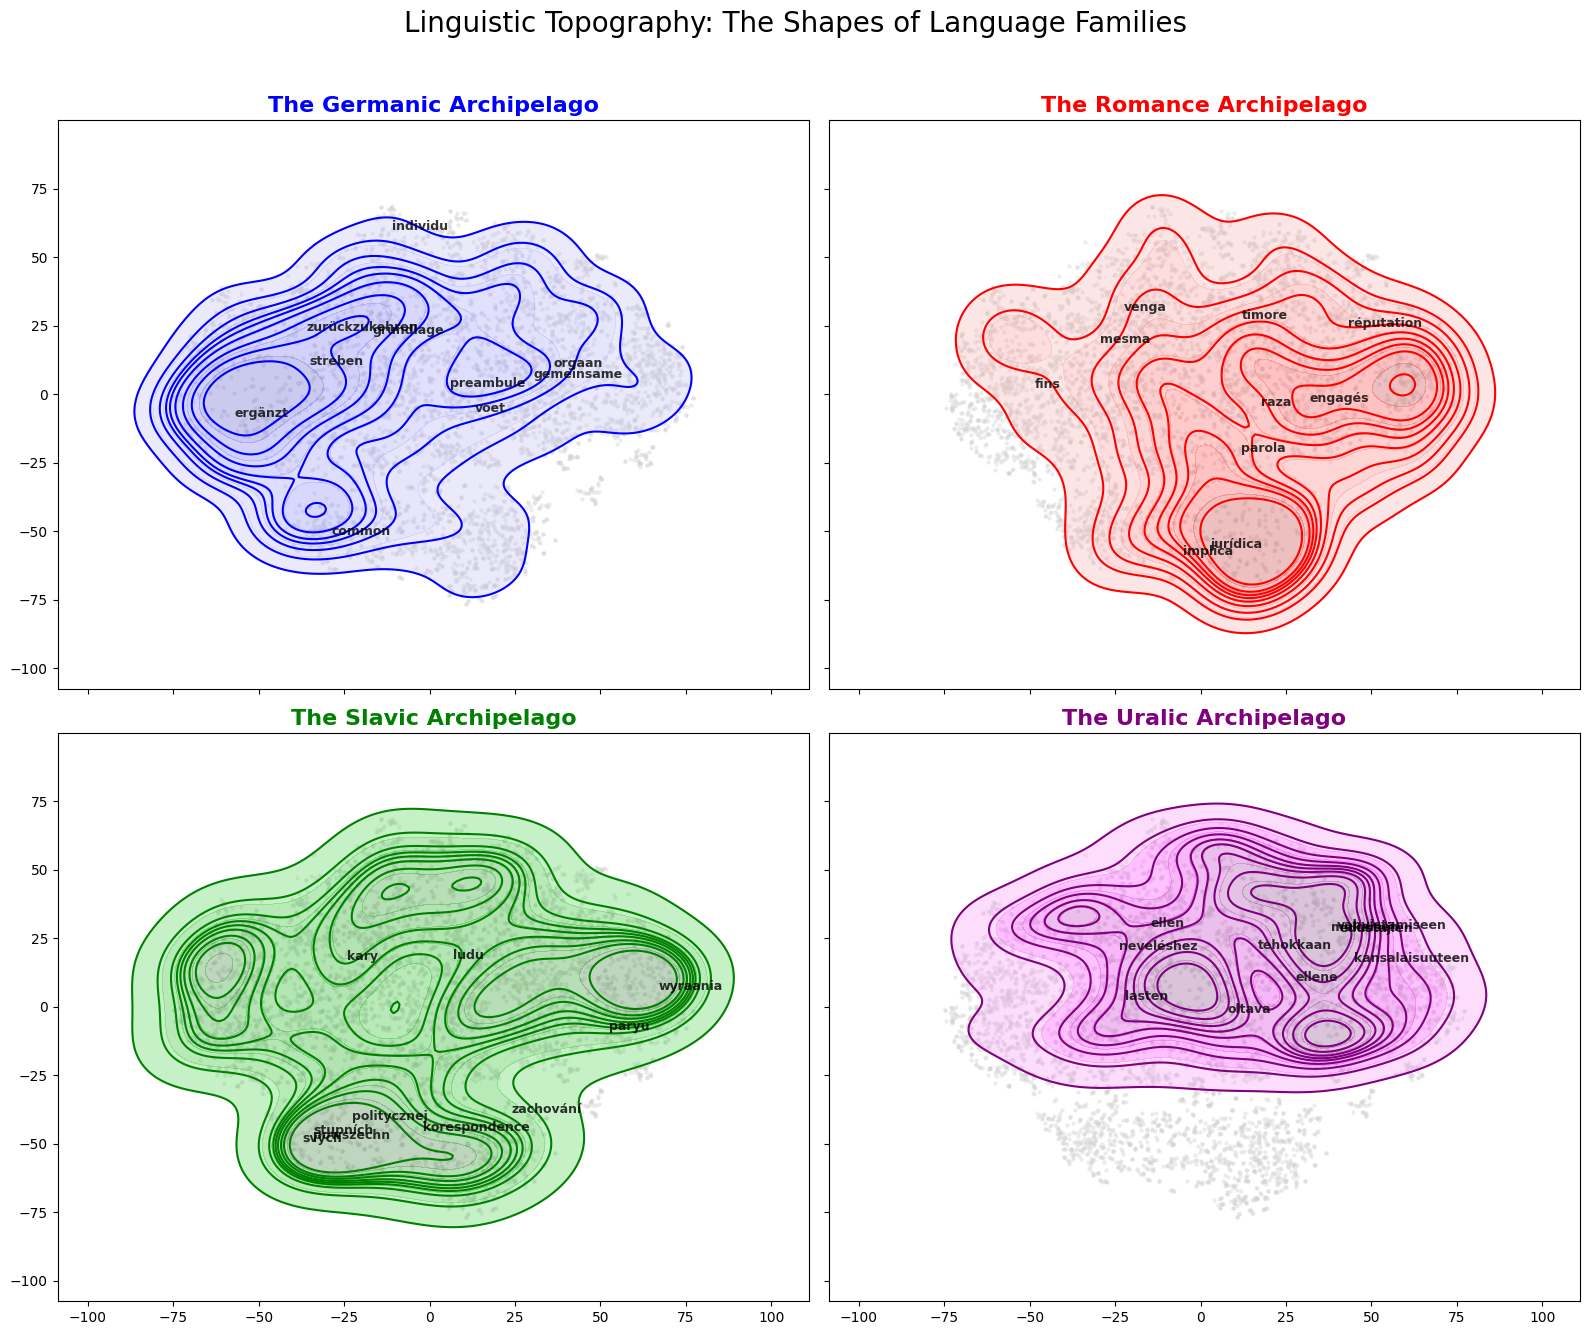

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from openTSNE import TSNE
import numpy as np

def visualize_lexical_topography(model, char2idx, lang_ids, min_len=4):
    """
    Visualizes the vocabulary as 'Topographic Maps' using Kernel Density Estimation (KDE).
    This avoids overcrowding by showing density contours instead of individual points.
    """
    print("Extracting and embedding vocabulary...")

    # 1. Data Collection (Same as before, but strictly filtered)
    word_data = []
    seen_words = set()

    for lid in lang_ids:
        raw = udhr.raw(lid).encode('latin-1', 'ignore').decode('latin-1')
        tokens = [t.lower() for t in nltk.tokenize.word_tokenize(raw) if t.isalnum()]

        # Filter for length to avoid noise from tiny function words
        unique_words = sorted(list(set([t for t in tokens if len(t) >= min_len])))

        for w in unique_words:
            # Avoid duplicates across languages for the "scatter" layer,
            # but keep them for the "density" layer if you want strict per-language density
            # Here we allow duplicates to show that 'nation' exists in multiple zones
            word_data.append({
                'word': w,
                'lang': lang_names[lid],
                'family': get_family(lang_names[lid])
            })

    df = pd.DataFrame(word_data)

    # 2. Vectorization
    sequences = []
    valid_indices = []
    for idx, row in df.iterrows():
        seq = [char2idx[c] for c in row['word'] if c in char2idx]
        if len(seq) > 0:
            sequences.append(seq)
            valid_indices.append(idx)

    df = df.iloc[valid_indices].copy()
    vectors = model.transform(sequences)

    # 3. t-SNE (Shared Space)
    # Using slightly higher perplexity to encourage global cluster separation
    print("Running t-SNE...")
    tsne = TSNE(n_components=2, perplexity=40, random_state=42, learning_rate='auto')
    coords = tsne.fit(vectors)

    df['x'] = coords[:, 0]
    df['y'] = coords[:, 1]

    # 4. The Clean Visualization
    families = ['Germanic', 'Romance', 'Slavic', 'Uralic']
    colors = {'Germanic': 'blue', 'Romance': 'red', 'Slavic': 'green', 'Uralic': 'purple'}

    fig, axes = plt.subplots(2, 2, figsize=(16, 14), sharex=True, sharey=True)
    axes = axes.flatten()

    plt.suptitle("Linguistic Topography: The Shapes of Language Families", fontsize=20, y=0.95)

    for i, fam in enumerate(families):
        ax = axes[i]

        # A. Background: Faint grey points for context (all other languages)
        other_data = df[df['family'] != fam]
        ax.scatter(other_data['x'], other_data['y'], c='lightgrey', s=5, alpha=0.3, label='Other')

        # B. Foreground: Density Contours for the specific family
        fam_data = df[df['family'] == fam]

        # KDE Plot (The "Topography")
        sns.kdeplot(
            data=fam_data, x='x', y='y',
            ax=ax,
            fill=True,
            alpha=0.3,
            color=colors[fam],
            thresh=0.05, # Remove lowest density areas to clean up noise
            levels=8
        )

        # Add outline
        sns.kdeplot(
            data=fam_data, x='x', y='y',
            ax=ax,
            color=colors[fam],
            linewidths=1.5,
            thresh=0.05
        )

        ax.set_title(f"The {fam} Archipelago", fontsize=16, color=colors[fam], fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("")

        # C. Annotations: Highlight a few key words to give context
        # We sample random words to label, prioritizing the 'densest' areas
        # (Simplified: just pick random words for now)
        sample_words = fam_data.sample(min(10, len(fam_data)), random_state=42)
        for _, row in sample_words.iterrows():
            ax.text(row['x'], row['y'], row['word'], fontsize=9, alpha=0.8, fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

# Run the cleaner visualization
visualize_lexical_topography(model_poly, char2idx, lang_ids)

Computing trajectories...


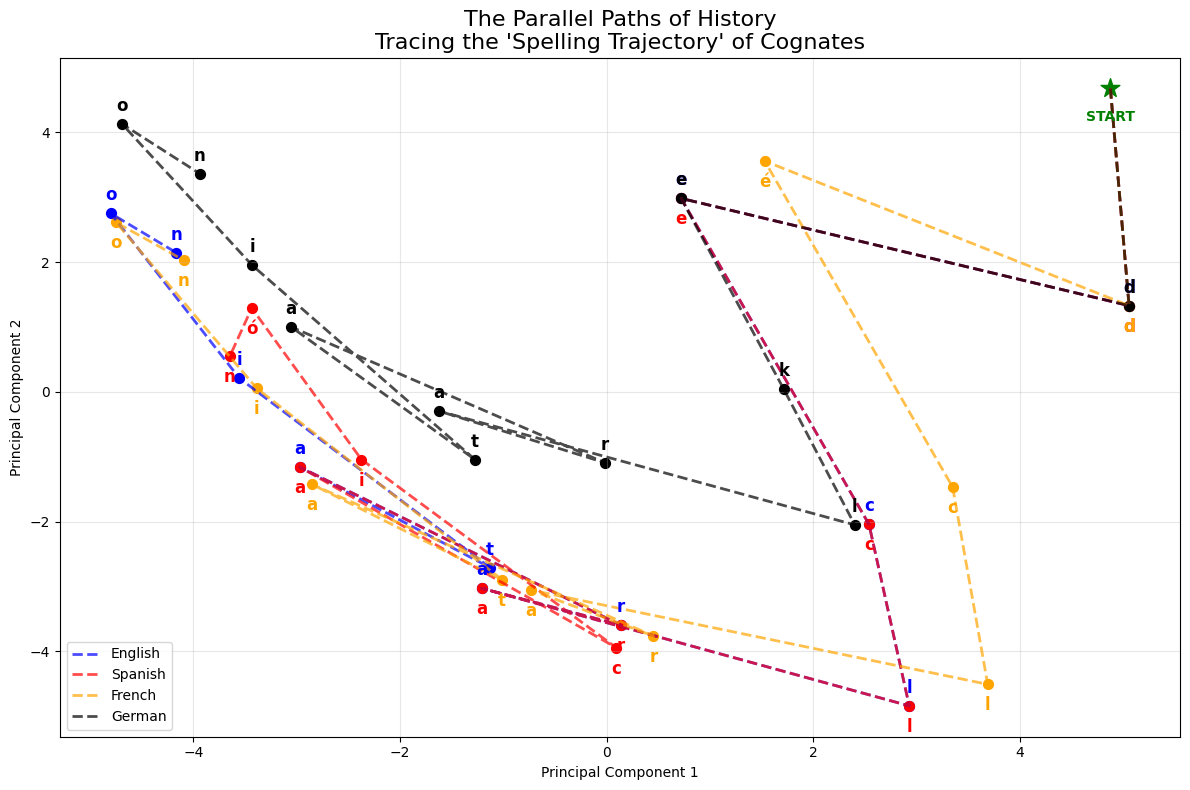

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_cognate_trajectories(model, char2idx):
    """
    Visualizes the step-by-step 'spelling path' of the same concept across languages.
    This demonstrates that Cognates (shared roots) form parallel geometric trajectories.
    """
    # 1. Define the Cognates (The same concept in 4 languages)
    # Note: These must use characters present in your training vocab
    cognates = {
        'English': 'declaration',
        'Spanish': 'declaración',
        'French':  'déclaration',
        'German':  'deklaration'
    }

    colors = {'English': 'blue', 'Spanish': 'red', 'French': 'orange', 'German': 'black'}

    # 2. Compute Trajectories (Hidden States at each step)
    paths = {}
    all_states = [] # Collect all points to fit PCA

    print("Computing trajectories...")
    for lang, word in cognates.items():
        # Create growing prefixes: [d], [de], [dec], [decl]...
        prefixes = [[char2idx[c] for c in word[:i+1] if c in char2idx] for i in range(len(word))]

        # Get the vector for each step
        # shape: (len_word, embedding_dim)
        states = model.transform(prefixes)

        # Add the "Start" state (Origin at 0,0)
        origin = np.zeros((1, states.shape[1]))
        full_path = np.vstack([origin, states])

        paths[lang] = full_path
        all_states.append(full_path)

    # 3. Project to 2D using PCA
    # We fit PCA on ALL points from ALL languages to find a shared "Spelling Plane"
    pca = PCA(n_components=2)
    combined_data = np.vstack(all_states)
    pca.fit(combined_data)

    # 4. Plot
    plt.figure(figsize=(12, 8))

    for lang, word in cognates.items():
        # Project this specific path
        path_2d = pca.transform(paths[lang])
        xs, ys = path_2d[:, 0], path_2d[:, 1]

        # Plot the Line
        plt.plot(xs, ys, label=lang, color=colors[lang], linewidth=2, alpha=0.7, linestyle='--')

        # Plot the Characters (The "Events")
        # We skip index 0 (the origin) for text labeling
        for i, char in enumerate(word):
            # Point is at index i+1
            px, py = xs[i+1], ys[i+1]

            # Offset text slightly to avoid overlap
            offset_y = 0.2 if lang in ['English', 'German'] else -0.4

            plt.scatter(px, py, color=colors[lang], s=50)
            plt.text(px, py + offset_y, char, fontsize=12, color=colors[lang], fontweight='bold', ha='center')

    # Add start point
    start_x, start_y = pca.transform(np.zeros((1, combined_data.shape[1])))[0]
    plt.scatter(start_x, start_y, c='green', s=200, marker='*')
    plt.text(start_x, start_y-0.5, "START", color='green', fontweight='bold', ha='center')

    plt.title("The Parallel Paths of History\nTracing the 'Spelling Trajectory' of Cognates", fontsize=16)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_cognate_trajectories(model_poly, char2idx)